In [2]:
import sys
sys.path.append('../input/fmixrepo/')
from fmix import make_low_freq_image, binarise_mask

!pip install timm
import timm

     |████████████████████████████████| 244 kB 887 kB/s eta 0:00:01


In [1]:
import os, math, time, random
import joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

from tqdm import tqdm
from glob import glob
from datetime import datetime
from kaggle_datasets import KaggleDatasets

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
from scipy.ndimage.interpolation import zoom

import cv2
import torch
import torchvision
import torch.nn.functional as F

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss

In [4]:
config = {
        'fold_num': 5,
        'seed': 719,
        'model_arch': 'tf_efficientnet_b4_ns',
        'img_size': 512,
        'epochs': 10,
        'train_bs': 16,
        'valid_bs': 32,
        'T_0': 10,
        'lr': 1e-4,
        'min_lr': 1e-6,
        'weight_decay':1e-6,
        'num_workers': 4,
        'accum_iter': 2, #for backprop with effectively larger batch size
        'verbose_step': 1,
        'device': 'cuda:0' if torch.cuda.is_available() else "cpu"
    }

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    return im_bgr[:, :, ::-1]

<BarContainer object of 5 artists>

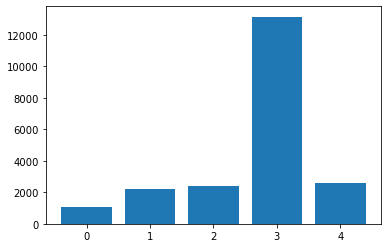

In [6]:
train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
count = train.label.value_counts().sort_index()
plt.bar(count.keys(), count)

In [7]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

class CassavaDataset(Dataset):
    def __init__(self, df, data_root, transforms=None,
            output_label=True, 
            one_hot_label=False,
            do_fmix=False, 
            fmix_params={
                'alpha': 1., 
                'decay_power': 3., 
                'shape': (config['img_size'], config['img_size']),
                'max_soft': True, 
                'reformulate': False},
            do_cutmix=False,
            cutmix_params={
                'alpha': 1}
            ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        
        self.transforms = transforms
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
                        
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                # mix target
                rate = mask.sum()/config['img_size']/config['img_size']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((config['img_size'], config['img_size']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (config['img_size'] * config['img_size']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                                        
       
        if self.output_label == True:
            return img, target
        else:
            return img

In [8]:
def get_train_transforms():
    return A.Compose([
            A.RandomResizedCrop(config['img_size'], config['img_size']),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.pytorch.ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return A.Compose([
            A.CenterCrop(config['img_size'], config['img_size'], p=1.),
            A.Resize(config['img_size'], config['img_size']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            A.pytorch.ToTensorV2(p=1.0),
        ], p=1.)

In [9]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_df = df.loc[trn_idx,:].reset_index(drop=True)
    valid_df = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(
                            train_df,
                            data_root,
                            transforms=get_train_transforms(),
                            output_label=True,
                            one_hot_label=False,
                            do_fmix=False,
                            do_cutmix=False)
    
    valid_ds = CassavaDataset(
                            valid_df,
                            data_root,
                            transforms=get_valid_transforms(),
                            output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
                            train_ds,
                            batch_size=config['train_bs'],
                            pin_memory=False,
                            drop_last=False,
                            shuffle=True,        
                            num_workers=config['num_workers'],
                            #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
        
    val_loader = torch.utils.data.DataLoader(
                            valid_ds, 
                            batch_size=config['valid_bs'],
                            num_workers=config['num_workers'],
                            shuffle=False,
                            pin_memory=False,
    )
    
    return train_loader, val_loader

In [10]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        with autocast():
            image_preds = model(imgs)
            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  config['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % config['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % config['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [12]:
class MyCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean'):
        super().__init__(weight=weight, reduction=reduction)
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
seed_everything(config['seed'])

folds = StratifiedKFold(n_splits=config['fold_num'],
                        shuffle=True,
                        random_state=config['seed']).split(np.arange(train.shape[0]),
                        train.label.values)

data_root_path = '../input/cassava-leaf-disease-classification/train_images/'
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('Training with {} started'.format(fold))
    print("Training dataset length: "+str(len(trn_idx))+" Validation dataset length: "+str(len(val_idx)))
    train_loader, val_loader = prepare_dataloader(train,
                                        trn_idx, 
                                        val_idx,
                                        data_root=data_root_path)

    device = torch.device(config['device'])
    
    model = CassvaImgClassifier(config['model_arch'], train.label.nunique(), pretrained=True).to(device)
    scaler = GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=1, eta_min=config['min_lr'], last_epoch=-1)
    
    loss_tr = nn.CrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    for epoch in range(config['epochs']):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

        torch.save(model.state_dict(),'{}_fold_{}_{}'.format(config['model_arch'], fold, epoch))
        
    del model, optimizer, train_loader, val_loader, scaler, scheduler
    torch.cuda.empty_cache()

Training with 0 started
Training dataset length: 17117 Validation dataset length: 4280


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
epoch 0 loss: 0.3729: 100%|██████████| 134/134 [01:15<00:00,  1.77it/s]


validation multi-class accuracy = 0.8680


epoch 1 loss: 0.3378: 100%|██████████| 134/134 [01:12<00:00,  1.86it/s]


validation multi-class accuracy = 0.8811


epoch 2 loss: 0.3865:  70%|██████▉   | 747/1070 [09:28<04:00,  1.34it/s]